## About this notebook

Feature selection:

If a feature has > 50% none, null for categorical, or 0 for numerical, then tentatively being removed for the model testing. 
Features with relative normal distribution were saved. 

Modeling:
Assuming from the lookup envr feature table, we will know zone, tmax/tmin -> temperature bucket, sun hour, plant data were subsetted and then run clustering. 
PCA reduced feature dimension from 109 to 44, with 95% cumulative explained variances.  
KMeans clustings with hyperparameter tuning is ongoing. silhouette score is used to evaluate k.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('plant_checkpoint.csv', index_col=0)

In [4]:
df.head()

In [5]:
df.columns

In [6]:
num_cols = ['height', 'width', 'emergence_days', 'zones']
str_cols = ['attracts', 'common', 'flower', 'fruit', 'leaf', 'water', 'genus', 'special_feature', 'scientific_name', 'description',
       'soil_conditions', 'texture', 'maintenance',
       'native_region', 'propagation', 'bloom_time', 'sun', 'problem_solvers',
       'type', 'family', 'color', 'temp_bucket']

In [7]:
l=len(df)
for col in str_cols:
    print(col, len(df[df[col]=='none'])/l*100)
    print('------')
    
for col in num_cols: 
    print(col, len(df[df[col]==0])/l*100)
    print('--------')

In [8]:
# drop cols that have > 50% missing values
spececis = ['common']
num_cols = ['height', 'width', 'zones']
cat_cols = ['water', 'special_feature', 'propagation', 'bloom_time', 'sun', 'problem_solvers',
       'type', 'temp_bucket']
# color need help， genus

In [9]:
features_cols = cat_cols + num_cols
saved_cols = features_cols + spececis
sub = df[saved_cols]
sub.drop_duplicates(inplace=True)

/tmp/ipykernel_1798/3476143780.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub.drop_duplicates(inplace=True)


In [10]:
temp_bucket = 'low'
zone = 7 

sub = sub[(sub['temp_bucket']== temp_bucket) & (sub['zones']== zone)]
sub.shape

(140362, 12)

In [11]:
feature = sub[features_cols]
target = sub['common']

In [12]:
data_train, data_test, target_train, target_test = train_test_split(feature, target, random_state=42)

In [13]:
data_train

,water,special_feature,propagation,bloom_time,sun,problem_solvers,type,temp_bucket,height,width,zones
8851,none,attracts birds,seed,summer bloom,full sun,good for privacy,vine,low,0,27,7
8604,dry,ground cover,none,may,full sun,heavy shade,herbaceous perennial,low,0,0,7
8851,none,low maintenance,stem cuttings,winter bloom,full sun,deer resistant,houseplant,low,0,23,7
8865,none,fragrance,layering,summer bloom,full shade,deer resistant,shrub,low,5,23,7
1784,wet,rain garden,none,june,full sun,erosion,rush or sedge,low,2,1,7
...,...,...,...,...,...,...,...,...,...,...,...
8865,none,fragrance,seed,fall bloom,part sun,deer resistant,shrub,low,4,11,7
8869,none,good for containers,division,winter interest,part sun,groundcover,perennial,low,0,5,7
8858,none,fragrance,grafting,winter interest,full sun,good for privacy,tree,low,5,19,7
8875,none,fragrance,stem cuttings,spring bloom,part sun,good for privacy,vine,low,18,9,7


In [14]:
# plt.figure(figsize=(20, 20))
# plt.subplots_adjust(hspace=1)
# plt.suptitle("Feature Distribution", fontsize=18, y=0.95)

# n_features = len(features_cols)
# ns_cols = 3
# ns_rows = int(n_features/ns_cols)+1

# for i, col in enumerate(features_cols):
#     ax = plt.subplot(ns_rows, ns_cols, i+1)
#     distribution = pd.DataFrame(df.groupby(col)['common'].count().sort_values())
#     distribution.plot.bar(y='common', ylabel = 'counts', title=f'Num of Plants Per {col}', ax=ax)

In [15]:
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

scaled_columns  = numerical_preprocessor.fit_transform(data_train[num_cols]) 
encoded_columns = categorical_preprocessor.fit_transform(data_train[cat_cols])

# Concatenate (Column-Bind) Processed Columns Back Together
processed_data = np.concatenate((scaled_columns, encoded_columns.todense()),axis=1)

In [16]:
processed_data.shape

(105271, 109)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


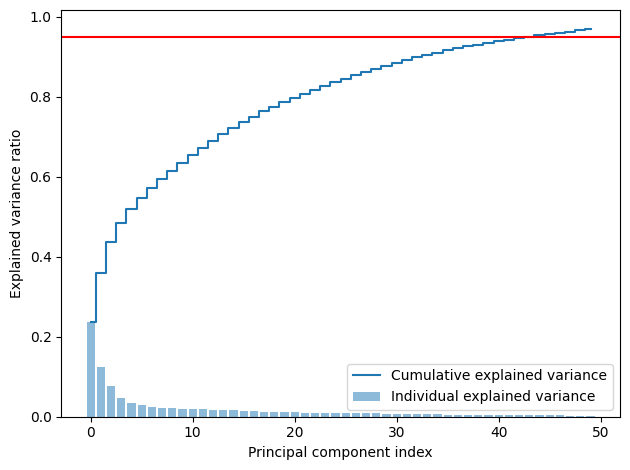

In [17]:
pca = PCA(n_components=50,random_state=42)

pca_model = pca.fit(processed_data)
ratio = pca_model.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(ratio)

plt.bar(range(len(cum_sum_eigenvalues)), ratio, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.axhline(y=0.95, color='r', linestyle='-')
plt.show()

In [18]:
cutoff = np.where(cum_sum_eigenvalues>0.95)[0][0]
pca = PCA(n_components=cutoff,random_state=42)
pca_data = pca.fit_transform(processed_data)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [19]:
pca_data.shape

(105271, 44)

In [22]:
# from sklearn.metrics import silhouette_samples, silhouette_score
# dbscan = DBSCAN(eps=0.3, min_samples=5000).fit(pca_data)
# labels = dbscan.labels_

# Get silhouette samples
# score = silhouette_score(processed_data, labels, metric='euclidean')
# print(str(k) + 'clusters:\n')
# print(score)
# print('------------')

In [21]:
# labels

array([-1, -1, -1, ..., -1, -1, -1])

In [23]:
# # # Kmeans
from sklearn.metrics import silhouette_samples, silhouette_score
n_clusters=[100, 50]

for k in n_clusters: 
  km = KMeans(n_clusters=k, random_state=42)
  km_model = km.fit(pca_data)

  labels = km_model.labels_
  # centroids = km.cluster_centers_

    # Get silhouette samples
  score = silhouette_score(pca_data, labels, metric='euclidean')
  print(str(k) + 'clusters:\n')
  print(score)
  print('------------')

100clusters:

0.13424274130719144
------------
50clusters:

0.11881242659687667
------------


In [24]:
n_clusters=[300, 250, 200, 150]

for k in n_clusters: 
  km = KMeans(n_clusters=k, random_state=42)
  km_model = km.fit(pca_data)

  labels = km_model.labels_
  # centroids = km.cluster_centers_

    # Get silhouette samples
  score = silhouette_score(pca_data, labels, metric='euclidean')
  print(str(k) + ' clusters:\n')
  print(score)
  print('------------')

300 clusters:

0.17748268304569184
------------
250 clusters:

0.16620327219163225
------------
200 clusters:

0.1526662571013002
------------
150 clusters:

0.14409016581469797
------------


In [ ]:
# agr = pca_data
# agr['labels']=labels
# agr['common']=target_train

# agr.groupby('common')